## Correlation Ambiguity

In [26]:
#Import relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad
import time
import numpy as np
from scipy.integrate import quad_vec
import scipy.stats as si
import pygad
import torch
from tqdm import tqdm
import random
from scipy.optimize import minimize, differential_evolution
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.ndimage import uniform_filter1d
from scipy.interpolate import UnivariateSpline
import scipy.optimize as opt
from numpy.linalg import inv

In [27]:
# Enable LaTeX fonts in plots
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

In [28]:
# Seeds
MASTER_SEED = 42
np.random.seed(MASTER_SEED)
random.seed(MASTER_SEED)

In [29]:
#Simulation parameters
T = 1.0                 # Time horizon (years)
N = 252                 # Number of time steps
dt = T / N              # Time increment
M = 10000               # Number of Monte Carlo simulations

#Interest rate parameters
kappa_r= 0.13                                       # Speed of mean reversion for interest rate                             # Escobar
varphi_r=0.0025                                     # Varphi_r/kappa_r is the long term mean of the interest rate           # Escobar
print("varphi_r/kappa_r: ", varphi_r / kappa_r)     # Varphi_r/kappa_r is the long term mean of the interest rate           # Escobar
sigma_r= 0.0566                                     # Volatility of the interest rate                                       # Escobar
r0 = varphi_r / kappa_r                             # Initial interest rate                                                 # Escobar

#Bond parameters
lambda_r = -0.1132                                  # Risk premium on interest rate                                         # Escobar
T_tilde = T                                         # Bond maturity

#Stock and variance 

# Parameters for Heston volatility process
kappa_v = 2.8278                                    # Speed of mean reversion for variance                                  # Escobar
varphi_v= 0.0563                                    # varphi_v/kappa_v is the long-run variance                             # Escobar
print("varphi_v/kappa_v: ", varphi_v / kappa_v)     # varphi_v/kappa_v is the long-run variance                             # Escobar
sigma_v = 0.2941                                    # Volatility of variance process                                        # Escobar
V0 = varphi_v / kappa_v                             # Initial variance                                                      # Escobar    
rho = -0.23                                         # Correlation between stock and variance shocks                         # Escobar                                  
lambda_v= -6.6932                                   # Risk premium on variance                                              # Escobar                 

# Parameters for stock price process
S0 = 100                                            # Initial stock price                                                   # Escobar
lambda_s = 2.2472                                   # Risk premium on diffusive risk                                        # Escobar                        
nu=-0.5973                                          # Factor loading stock and rate                                         # Escobar 
lambda_j = 12.3                                     # Jump intensity                                                        # Pan
lambda_j_q = lambda_j*2                             # Jump intensity Q                                                      # Liu and Pan
mu= -0.10                                           # Jump amplitude                                                        # Liu and Pan

# Parameters for jump process
lambda_J = 0.5                                      # Jump frequency                                                        # Liu and Pan

# Parameters for option pricing 
num_K= 9                                            # Number of strikes         

# General parameters
gamma= 3                                            # Risk aversion parameter                                              # Liu and Pan


varphi_r/kappa_r:  0.019230769230769232
varphi_v/kappa_v:  0.019909470259565742


In [30]:
# Function for b(T-t)
def b_func(T_tilde, t, kappa_r, lambda_r):
    xi = np.sqrt((kappa_r + lambda_r) ** 2 + 2 * sigma_r ** 2)
    num = 2 * (np.exp(xi * (T_tilde - t)) - 1)
    den = 2 * xi + (xi + kappa_r + lambda_r) * (np.exp(xi * (T_tilde - t)) - 1)
    return num / den

In [31]:
print("Return on stock: ", r0+lambda_v*rho*V0+lambda_s*np.sqrt(1-rho**2)*V0+nu*lambda_r*r0+mu*(lambda_j-lambda_j_q)*V0)
print("Return on bond: ", r0-lambda_r*b_func(1,0,kappa_r,lambda_r)*r0)

Return on stock:  0.11921014430729271
Return on bond:  0.021388365884807477


In [32]:
# Result arrays
call_prices = np.zeros((M, N + 1, num_K))
put_prices = np.zeros((M, N + 1, num_K))
delta_call = np.zeros((M, N + 1, num_K))
delta_put = np.zeros((M, N + 1, num_K))
vega_call = np.zeros((M, N + 1, num_K))
vega_put = np.zeros((M, N + 1, num_K))
rho_call = np.zeros((M, N + 1, num_K))
rho_put = np.zeros((M, N + 1, num_K))
jump_call = np.zeros((M, N + 1, num_K))
jump_put = np.zeros((M, N + 1, num_K))

# Paths
S_paths = np.zeros((M, N + 1))
V_paths = np.zeros((M, N + 1))
r_paths = np.zeros((M, N + 1))
N_J = np.random.poisson(lambda_J * dt, size=(M, N + 1)) 
B= np.zeros((M, N + 1))
M_t= np.zeros((M, N + 1))
dW_r = np.random.normal(0, np.sqrt(dt), size=(M, N + 1))
dW_v = np.random.normal(0, np.sqrt(dt), size=(M, N + 1))
dW_s = np.random.normal(0, np.sqrt(dt), size=(M, N + 1))


def simulation(S_t, V_t, r_t, rho, nu, lambda_v):
    S_paths[:, 0] = S_t
    V_paths[:, 0] = V_t
    r_paths[:, 0] = r_t
    B[:, 0] = 1
    M_t[:, 0] = 1

    for j in range(1, N + 1):
        S_prev = S_paths[:, j - 1]
        V_prev = V_paths[:, j - 1]
        r_prev = r_paths[:, j - 1]

        # CIR
        r_new = r_prev + (varphi_r - kappa_r * r_prev) * dt + sigma_r * np.sqrt(np.maximum(r_prev, 0)) * dW_r[:, j]
        r_new = np.maximum(r_new, 0)

        # Heston
        V_new = V_prev + (varphi_v - kappa_v * V_prev) * dt + sigma_v * np.sqrt(np.maximum(V_prev, 0)) * dW_v[:, j]
        V_new = np.maximum(V_new, 0)

        # Stock Diffusion
        diffusion = np.sqrt(V_prev) * (rho * dW_v[:, j] + np.sqrt(1 - rho**2) * dW_s[:, j]) * S_prev+ nu*sigma_r*np.sqrt(r_prev)*dW_r[:, j]*S_prev
        
        # Jump Term
        jump_term = S_prev * mu * (N_J[:, j]- lambda_j * V_prev * dt)
        
        # Stock Drift
        drift = (r_prev+lambda_v*rho*V_prev+lambda_s*np.sqrt(1 - rho**2)*V_prev+nu*lambda_r*r_prev+mu*(lambda_j-lambda_j_q)*V_prev) * S_prev * dt

        # Stock Process
        S_new = S_prev + drift + diffusion + jump_term

        # Money Market
        M_t[:, j] = M_t[:, j - 1] * np.exp(r_prev * dt)


        # Bond Process
        t_curr= j *dt
        b_T_t = b_func(T_tilde, t_curr, kappa_r, lambda_r)
        drift_B = (r_prev - lambda_r * b_T_t*r_prev) * B[:, j - 1] * dt
        diffusion_B =  -b_T_t * sigma_r * np.sqrt(r_prev) * B[:, j - 1] * dW_r[:, j]
        B[:, j] = B[:, j - 1] + drift_B + diffusion_B

        S_paths[:, j] = S_new
        V_paths[:, j] = V_new
        r_paths[:, j] = r_new

    return S_paths, V_paths, r_paths

simulation(S0, V0, r0, rho, nu, lambda_v)

def simulate_bumped_V_local(S_curr, V_curr, r_curr, N_Jump, dW_v, dW_s, dW_r, epsilon, rho, nu):
    V_bumped = np.maximum(V_curr + epsilon, 0)
    jump_term = S_curr * mu * (N_Jump - lambda_j * V_bumped * dt)
    drift = (r_curr + lambda_v * rho * V_bumped + lambda_s * np.sqrt(1 - rho**2) * V_bumped +
             nu * lambda_r * r_curr + mu * (lambda_j - lambda_j_q) * V_bumped) * S_curr * dt
    diffusion = (np.sqrt(V_bumped) * (rho * dW_v + np.sqrt(1 - rho**2) * dW_s) +
                 nu * sigma_r * np.sqrt(r_curr) * dW_r) * S_curr
    return S_curr + drift + diffusion + jump_term

def simulate_bumped_r_local(S_curr, V_curr, r_curr, N_Jump, dW_v, dW_s, dW_r, epsilon, rho, nu):
    r_bumped = np.maximum(r_curr + epsilon, 0)
    jump_term = S_curr * mu * (N_Jump - lambda_j * V_curr * dt)
    drift = (r_bumped + lambda_v * rho * V_curr + lambda_s * np.sqrt(1 - rho**2) * V_curr +
             nu * lambda_r * r_bumped + mu * (lambda_j - lambda_j_q) * V_curr) * S_curr * dt
    diffusion = (np.sqrt(V_curr) * (rho * dW_v + np.sqrt(1 - rho**2) * dW_s) +
                 nu * sigma_r * np.sqrt(r_bumped) * dW_r) * S_curr
    return S_curr + drift + diffusion + jump_term

def numerical_option_pricing(S, K):
    return max(S - K, 0), max(K - S, 0)

epsilon_S = 1e-4
epsilon_V = 1e-3  # for Vega
epsilon_r = 1e-3  # for Rho

def prices_greeks(rho, nu):

    #for i in tqdm(range(M), desc="Simulating Monte Carlo Paths"):
    for i in range(M):
        for j in range(N + 1):
            S_mean = np.mean(S_paths[:, j])
            S_curr = S_paths[i, j]
            strike_prices = np.linspace(S_mean * 0.8, S_mean * 1.2, num_K)
            S_bump_S_up = S_curr + epsilon_S
            S_bump_S_down = S_curr - epsilon_S
            S_bump_jump = S_curr * (1 + mu)

            S_bumped_V = simulate_bumped_V_local(S_curr, V_paths[i, j], r_paths[i, j], N_J[i, j], dW_v[i, j], dW_s[i, j], dW_r[i, j], epsilon_V, rho, nu)
            S_bumped_r = simulate_bumped_r_local(S_curr, V_paths[i, j], r_paths[i, j], N_J[i, j], dW_v[i, j], dW_s[i, j], dW_r[i, j], epsilon_r, rho, nu)

            for k, K in enumerate(strike_prices):
                call, put = numerical_option_pricing(S_curr, K)
                call_prices[i, j, k] = call
                put_prices[i, j, k] = put
                call_V, put_V = numerical_option_pricing(S_bumped_V, K)
                call_r, put_r = numerical_option_pricing(S_bumped_r, K)
                call_S_up, put_S_up = numerical_option_pricing(S_bump_S_up, K)
                call_S_down, put_S_down = numerical_option_pricing(S_bump_S_down, K)
                call_J, put_J = numerical_option_pricing(S_bump_jump, K)

                delta_call[i, j, k] = (call_S_up - call_S_down) / (epsilon_S*2)
                delta_put[i, j, k] = (put_S_up - put_S_down) / (epsilon_S*2)
                vega_call[i, j, k] = (call_V - call) / epsilon_V
                vega_put[i, j, k] = (put_V - put) / epsilon_V
                rho_call[i, j, k] = (call_r - call) / epsilon_r
                rho_put[i, j, k] = (put_r - put) / epsilon_r
                jump_call[i, j, k] = (call_J - call)
                jump_put[i, j, k] = (put_J - put)

prices_greeks(rho, nu)

S=S_paths
V=V_paths
r=r_paths


In [33]:
# Indicies
call_indices_fixed = 4
put_indices_fixed = 3  
t_idx=int(11/12*N)

In [34]:
#Log returns
log_returns = np.log([
    S[:, -1] / S[:, t_idx],                 
    (call_prices[:, -1, call_indices_fixed]+0.5) / (call_prices[:, t_idx, call_indices_fixed]+0.5),
    (put_prices[:, -1, put_indices_fixed]+0.5) / (put_prices[:, t_idx, put_indices_fixed]+0.5),    
    B[:, -1] / B[:, t_idx],            
])

log_returns = log_returns.T  

mu_vec = np.mean(log_returns, axis=0)    
sigma_vec = np.std(log_returns, axis=0)  

print("Mean returns: ", mu_vec)
print("Volatilities: ", sigma_vec)

Mean returns:  [0.00678643 0.0265653  0.04722748 0.00161366]
Volatilities:  [4.67106534e-02 6.69931085e-01 6.31410813e-01 5.86294386e-04]


In [35]:
def estimate_correlation_bounds(log_returns, alpha=0.05):
    n_samples, n_assets = log_returns.shape
    bounds = []
    z_alpha = norm.ppf(1 - alpha / 2)

    for i in range(n_assets):
        for j in range(i + 1, n_assets):
            x = log_returns[:, i]
            y = log_returns[:, j]

            R_p = np.corrcoef(x, y)[0, 1]
            R_p = np.clip(R_p, -0.999, 0.999)  # Avoid numerical instability

            z = np.arctanh(R_p)
            delta = z_alpha / np.sqrt(n_samples - 3)

            z_lower = z - delta
            z_upper = z + delta

            rho_lower = np.tanh(z_lower)
            rho_upper = np.tanh(z_upper)

            bounds.append((rho_lower, rho_upper))

    return bounds

rho_bounds = estimate_correlation_bounds(log_returns, alpha=0.05)

In [36]:
print("Correlation bounds:")
for i, (lower, upper) in enumerate(rho_bounds):
    print(f"Pair {i}: ({lower:.4f}, {upper:.4f})")

Correlation bounds:
Pair 0: (0.5860, 0.6112)
Pair 1: (-0.5915, -0.5654)
Pair 2: (-0.0023, 0.0368)
Pair 3: (-0.1240, -0.0852)
Pair 4: (-0.0044, 0.0347)
Pair 5: (-0.0452, -0.0060)


In [37]:
log_returns_trimmed = log_returns
mu_vec_trimmed = np.mean(log_returns_trimmed, axis=0)
sigma_vec_trimmed = np.std(log_returns_trimmed, axis=0)
s_marginal_trimmed = mu_vec_trimmed / sigma_vec_trimmed
N_trimmed = len(mu_vec_trimmed)

def estimate_correlation_bounds(log_returns, alpha=0.05):
    n_samples, n_assets = log_returns.shape
    bounds = []
    z_alpha = norm.ppf(1 - alpha / 2)
    for i in range(n_assets):
        for j in range(i + 1, n_assets):
            x = log_returns[:, i]
            y = log_returns[:, j]
            R_p = np.corrcoef(x, y)[0, 1]
            R_p = np.clip(R_p, -0.999, 0.999)
            z = np.arctanh(R_p)
            delta = z_alpha / np.sqrt(n_samples - 3)
            bounds.append((np.tanh(z - delta), np.tanh(z + delta)))
    return bounds

rho_bounds_trimmed = estimate_correlation_bounds(log_returns_trimmed)

def worst_case_correlation(s, rho_bounds):
    idx_upper = np.triu_indices(len(s), 1)
    def make_corr_matrix(x):
        rho = np.eye(len(s))
        rho[idx_upper] = x
        rho[(idx_upper[1], idx_upper[0])] = x
        return rho
    def objective(x):
        rho = make_corr_matrix(x)
        try:
            eigvals = np.linalg.eigvalsh(rho)
            if np.min(eigvals) < 1e-4:
                return 1e6
            inv_rho = np.linalg.inv(rho)
            return s.T @ inv_rho @ s
        except np.linalg.LinAlgError:
            return 1e6
    x0 = np.zeros(len(rho_bounds))
    result = opt.minimize(objective, x0, bounds=rho_bounds, method="SLSQP")
    if result.success:
        return make_corr_matrix(result.x)
    else:
        raise RuntimeError("Worst-case correlation optimization failed.")

rho_star_matrix = worst_case_correlation(s_marginal_trimmed, rho_bounds_trimmed)

Sigma_star = np.diag(sigma_vec_trimmed) @ rho_star_matrix @ np.diag(sigma_vec_trimmed)
cond_before = np.linalg.cond(Sigma_star)
Sigma_star_reg = Sigma_star + 1e-3 * np.eye(N_trimmed)
cond_after = np.linalg.cond(Sigma_star_reg)

inv_Sigma_star = np.linalg.inv(Sigma_star_reg)
gamma = 3
A = gamma - 1
pi_star = (1 / A) * inv_Sigma_star @ mu_vec_trimmed

mm = 1-np.sum(pi_star)
pi_star = np.append(pi_star, mm)

asset_names = ["Stock", "Call", "Put", "Bond", "MM"]
for name, w in zip(asset_names, pi_star):
    print(f"{name:>10}: {w:.4f}")


     Stock: 1.9927
      Call: -0.0357
       Put: 0.1375
      Bond: 0.8048
        MM: -1.8993


In [38]:
def diversification_metrics_full(pi, asset_labels=None):
    pi_abs = np.abs(pi)
    w = pi_abs / np.sum(pi_abs)

    # --- HHI ---
    HHI = np.sum(w ** 2)

    # --- ENB (entropy-based) ---
    with np.errstate(divide='ignore', invalid='ignore'):
        entropy_terms = w * np.log(w)
        entropy_terms = np.nan_to_num(entropy_terms, nan=0.0, neginf=0.0, posinf=0.0)
    ENB = np.exp(-np.sum(entropy_terms))

    if asset_labels is None:
        asset_labels = [f"Asset {i}" for i in range(len(pi))]
    for label, weight in zip(asset_labels, pi):
        print(f"{label:>15}: {weight:>8.4f}")
    print(f"\nHerfindahl-Hirschman Index (HHI): {HHI:.4f}")
    print(f"Effective Number of Bets (ENB):   {ENB:.2f}")

    return HHI, ENB

asset_labels = ["Stock", "Call", "Put", "Bond", "MM"]
pi_trimmed = pi_star[:4]

diversification_metrics_full(pi_trimmed, asset_labels)


          Stock:   1.9927
           Call:  -0.0357
            Put:   0.1375
           Bond:   0.8048

Herfindahl-Hirschman Index (HHI): 0.5256
Effective Number of Bets (ENB):   2.26


(0.5256250781103915, 2.263745710334109)

In [39]:
asset_names = ["Stock", "Call", "Put", "Bond"]
for i, name in enumerate(asset_names):
    print(f"{name:>10}: {mu_vec_trimmed[i]:.4f} / {sigma_vec_trimmed[i]:.4f} = {mu_vec_trimmed[i] / sigma_vec_trimmed[i]:.4f}")

     Stock: 0.0068 / 0.0467 = 0.1453
      Call: 0.0266 / 0.6699 = 0.0397
       Put: 0.0472 / 0.6314 = 0.0748
      Bond: 0.0016 / 0.0006 = 2.7523


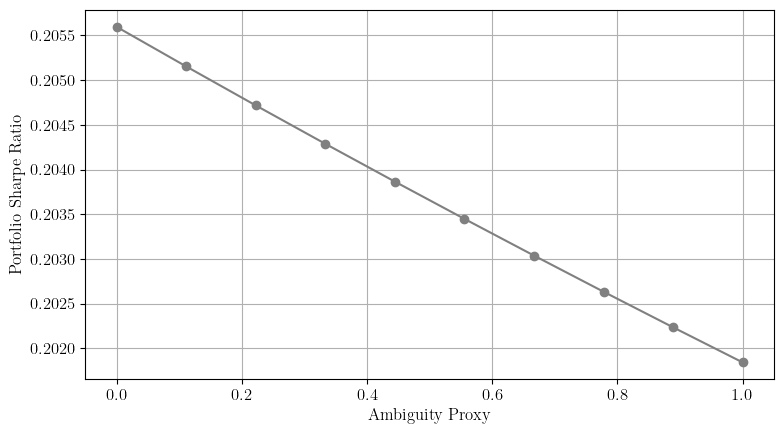

In [41]:
asset_names = ["Stock", "Call", "Put", "Bond"]
asset_keys = ["pi_s", "pi_o1", "pi_o2", "pi_b"]

style_dict = {
    "pi_s": {"color": "dimgray", "linestyle": "-"},
    "pi_b": {"color": "gray", "linestyle": "--"},
    "pi_o1": {"color": "blue", "linestyle": "--"},
    "pi_o2": {"color": "green", "linestyle": ":"},
    "pi_mm": {"color": "black", "linestyle": "-."}
}

def blend_correlation_matrices(rho_empirical, rho_worst, num_points=10):
    """
    Linearly blend from the empirical correlation matrix to the worst-case correlation matrix.

    Returns a list of blended matrices, where:
    alpha = 0 --> 100% empirical,
    alpha = 1 --> 100% worst-case.
    """
    blends = []
    for alpha in np.linspace(0, 1, num_points):
        blended = (1 - alpha) * rho_empirical + alpha * rho_worst
        blends.append(blended)
    return blends

num_points = 10
alphas = np.linspace(0, 1, num_points)
rho_empirical_matrix = np.corrcoef(log_returns_trimmed.T)
blended_rhos = blend_correlation_matrices(rho_empirical_matrix, rho_star_matrix, num_points)

results = []

for alpha, rho in zip(alphas, blended_rhos):
    Sigma = np.diag(sigma_vec_trimmed) @ rho @ np.diag(sigma_vec_trimmed)
    Sigma_reg = Sigma + 1e-3 * np.eye(N_trimmed)
    inv_Sigma = inv(Sigma_reg)

    weights = (1 / (gamma - 1)) * inv_Sigma @ mu_vec_trimmed
    weights /= np.sum(weights)

    port_return = weights @ mu_vec_trimmed
    port_vol = np.sqrt(weights @ Sigma_reg @ weights)
    sharpe = port_return / port_vol

    ambiguity = np.linalg.norm(rho - rho_empirical_matrix, ord='fro')

    asset_corr = [np.mean([rho[i, j] for j in range(N_trimmed) if j != i]) for i in range(N_trimmed)]
    asset_sharpe= [mu_vec_trimmed[i] / sigma_vec_trimmed[i] for i in range(N_trimmed)]
    asset_sharpe_contrib = [weights[i] * mu_vec_trimmed[i] / sigma_vec_trimmed[i] for i in range(N_trimmed)]

    results.append({
        "alpha": alpha,
        "ambiguity": ambiguity,
        "sharpe": sharpe,
        "weights": weights,
        "asset_corr": asset_corr,
        "asset_sharpe_contrib": asset_sharpe_contrib
    })

x_vals = [r["alpha"] for r in results]  # Normalized ambiguity level (0 to 1)
sharpe_ratios = [r["sharpe"] for r in results]

asset_corr_trajectories = {i: [r["asset_corr"][i] for r in results] for i in range(N_trimmed)}
asset_sharpe_contributions = {i: [r["asset_sharpe_contrib"][i] for r in results] for i in range(N_trimmed)}
asset_weights = {i: [r["weights"][i] for r in results] for i in range(N_trimmed)}

fig, axs = plt.subplots(1, 1, figsize=(8, 5))
fig.subplots_adjust(wspace=0.3)

axs.plot(x_vals, sharpe_ratios, marker='o', linestyle='-', color='grey')
#axs.set_title("Efficient Frontier:\nAmbiguity vs Sharpe Ratio")
axs.set_xlabel("Ambiguity Proxy")
axs.set_ylabel("Portfolio Sharpe Ratio")
axs.grid(True)

plt.tight_layout(rect=[0, 0.1, 1, 1]) 
plt.savefig("Sensitivity_Combined_2.png", dpi=600, bbox_inches='tight')
plt.show()
